In [1]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

/home/henrique/Documents/tensorflow-production/.venv/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


'2.3.0'

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [10]:
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
391/391 [==============================] - 143s 366ms/step - loss: 1.4506 - sparse_categorical_accuracy: 0.4781
Epoch 2/10
391/391 [==============================] - 167s 428ms/step - loss: 0.9930 - sparse_categorical_accuracy: 0.6490
Epoch 3/10
391/391 [==============================] - 165s 421ms/step - loss: 0.8041 - sparse_categorical_accuracy: 0.7189
Epoch 4/10
391/391 [==============================] - 164s 419ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.7585
Epoch 5/10
391/391 [==============================] - 165s 422ms/step - loss: 0.5864 - sparse_categorical_accuracy: 0.7959
Epoch 6/10
391/391 [==============================] - 156s 398ms/step - loss: 0.4986 - sparse_categorical_accuracy: 0.8268
Epoch 7/10
391/391 [==============================] - 139s 355ms/step - loss: 0.4159 - sparse_categorical_accuracy: 0.8535
Epoch 8/10
391/391 [==============================] - 132s 338ms/step - loss: 0.3331 - sparse_categorical_accuracy: 0.8850
Epoch 9/10
391/3

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 5s 17ms/step - loss: 0.9686 - sparse_categorical_accuracy: 0.7503


In [12]:
print(f"Test accuracy is: {test_accuracy}")

Test accuracy is: 0.7502999901771545


In [13]:
model_dir = "model/"
version = 1

In [14]:
export_path = os.path.join(model_dir, str(version))

In [15]:
if os.path.isdir(export_path):
    !rm -rf {export_path}

In [19]:
# tf.saved_model.save(tf.keras.backend.get_session(), export_dir=export_path,
#                           inputs={"input_image": model.input},
#                           outputs={t.name for t in model.outputs})

In [20]:
model.save(export_path)

INFO:tensorflow:Assets written to: model/1/assets


In [23]:
os.environ["model_dir"] = os.path.abspath(model_dir)

In [24]:
%%bash --bg 
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${model_dir}" >server.log 2>&1

In [26]:
!tail server.log

2020-08-01 13:36:51.916686: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:295] Reading SavedModel debug info (if present) from: /home/henrique/Documents/tensorflow-production/tf-serving/model/1
2020-08-01 13:36:51.917752: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-01 13:36:52.029152: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2020-08-01 13:36:52.115873: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /home/henrique/Documents/tensorflow-production/tf-serving/model/1
2020-08-01 13:36:52.124436: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 225291 microseconds.
2020-08-01 13:36:52.125703: I tensorflow_serving/servables/tensorflow/sav

In [53]:
random_image = np.random.randint(0, len(X_test))

In [54]:
random_image

2196

In [55]:
data = json.dumps({"signature": "serving_default", "instances": [X_test[random_image].tolist()]})

In [56]:
headers = {"Content-Type": "application/json"}

In [57]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)
json_response

<Response [200]>

In [58]:
predictions = json.loads(json_response.text)["predictions"]
predictions

[[0.000501362199,
  2.76137744e-08,
  2.41261633e-09,
  6.91041e-08,
  3.64047423e-08,
  1.19345601e-11,
  3.02430542e-12,
  1.21702477e-15,
  0.999498487,
  2.48704973e-10]]

Predicted: ship
Actual: ship


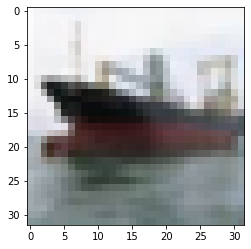

In [59]:
print("Predicted:", class_names[np.argmax(predictions[0])])
print("Actual:",  class_names[y_test[random_image][0]])
plt.imshow(X_test[random_image])
plt.show()